# Training Yolo with MS Coco 

In [1]:
# all imports
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath('./src'))


from torchvision.datasets import CocoDetection
from torchvision import transforms

from datasets.preprocess import *
from datasets.yayolo_coco_dataset import YaYoloCocoDataset

from yolo.yolo import Yolo
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
print(torch.cuda.is_available())

[2019-11-21 17:02:38,976] {device:11} INFO - ************ Using cuda as device **************


True


In [2]:
cfg_file = './cfg/yolov3.cfg'
weight_file = './cfg/yolov3.weights'
namesfile = './cfg/coco.names'
batch_size = 2
#COCO_IMAGES_DIR = '/home/peter/datasets/coco-small/cocoapi/images/train2014'
COCO_IMAGES_DIR = '/home/ubuntu/datasets/coco/train2014'
#COCO_ANNOTATIONS_FILE = '/home/peter/datasets/coco-small/cocoapi/annotations/instances_train2014_10_per_category.json'
COCO_ANNOTATIONS_FILE = '/home/ubuntu/datasets/coco/annotations/instances_train2014.json'




image_and_target_transform = Compose([
        ConvertXandYToCenterOfBoundingBox(),
        AbsoluteToRelativeBoundingBox(),
        SquashResize(416),
        CocoToTensor()
    ])

ya_yolo_dataset = YaYoloCocoDataset(images_dir=COCO_IMAGES_DIR, 
                                    annotations_file=COCO_ANNOTATIONS_FILE,
                                    transforms=image_and_target_transform,
                                    batch_size=batch_size)
trainloader = torch.utils.data.DataLoader(ya_yolo_dataset, batch_size=2, shuffle=False)

images, targets, image_paths = next(iter(trainloader))
print(images.shape)


model = Yolo(cfg_file=cfg_file,namesfile=namesfile, batch_size=batch_size)
model.load_weights(weight_file)





loading annotations into memory...
Done (t=9.57s)
creating index...
index created!
torch.Size([2, 3, 416, 416])
Loading weights. Please Wait...



Number of images:  82783
processing batch 1 with 2 annotated objects per image ...


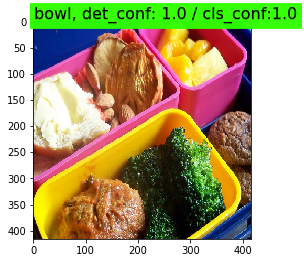

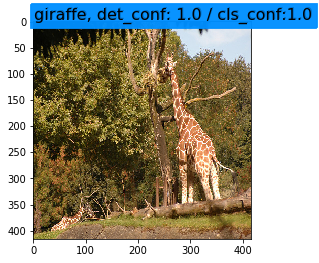

RuntimeError: Expected object of backend CUDA but got backend CPU for sequence element 1 in sequence argument at position #1 'tensors'

In [3]:
from yolo.training import training
lr = 0.001
lambda_coord=5
lambda_no_obj=0.5

summary_writer = SummaryWriter(comment=f' batch_size={batch_size} lr={lr}')

training(model=model, ya_yolo_dataset=ya_yolo_dataset, model_dir='./models',
         summary_writer=summary_writer, 
         lambda_coord=lambda_coord,
         lambda_no_obj=lambda_no_obj,
         epochs=2,
         lr=lr,
         limit=None, debug=True, print_every=10)